In [1]:
import numpy as np
from tensorflow.keras.layers import (Dense,Conv2D,MaxPooling2D,Conv2DTranspose,
                                     Flatten,Reshape,BatchNormalization,Activation,
                                     Input,Concatenate,UpSampling2D,Dropout)
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

In [2]:
data = tfds.load('smallnorb',batch_size=64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/2.0.0.incomplete210SI6/smallnorb-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/2.0.0.incomplete210SI6/smallnorb-test.tfrecord*...:   0%|       …

Dataset smallnorb downloaded and prepared to /root/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.


In [3]:
#instance : there are 10 instances per categorie so instances = 10*5 = 50
#label_azimuth : there are 18 azmuth values ranging from (0,340,20) --> (0,20,40,60,...,340)
#label categorie : 5 (four-legged animals, human figures, airplanes, trucks, or cars)
#elivation = 9 ranging from (30,70,5) --> (30,35,40,45,...,70)
#lighting condithion = 6

In [4]:
train_dataset = data['train']
test_dataset = data['test']

In [5]:
def create_batch(dataset,batch_size=32):
  batch = next(dataset)
  im1 = tf.cast(batch['image'],dtype=tf.float32)
  im2 = tf.cast(batch['image2'],dtype=tf.float32)
  imgs = [im1/255.0,im2/255.0]
  labs = [batch['label_category'],
          batch['instance'],
          batch['label_azimuth'],
          batch['label_elevation'],
          batch['label_lighting']]

  return imgs,labs


In [6]:
def create_model():
  filters = [16,32,64]
  input_shape = (96,96,1)

  in1 = Input(input_shape)
  in2 = Input(input_shape)

  c1 = Conv2D(filters[0],kernel_size=3,padding='same',activation='relu')(in1)
  #c1 = BatchNormalization()(c1)
  c2 = Conv2D(filters[0],kernel_size=3,padding='same',activation='relu')(in2)
  #c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1)(c2)

  cat1 = Concatenate()([c1,c2])

  comb1 = Conv2D(filters[1],kernel_size=3,padding='same',activation='relu')(cat1)
  #comb1 = BatchNormalization()(comb1)
  comb1 = Conv2D(filters[1],kernel_size=3,padding='same',activation='relu')(comb1)
  #comb1 = BatchNormalization()(comb1)
  comb1 = Dropout(0.1)(comb1)

  m1 = MaxPooling2D()(comb1)

  comb2 = Conv2D(filters[2],kernel_size=3,padding='same',activation='relu')(m1)
  #comb2 = BatchNormalization()(comb2)
  comb2 = Conv2D(filters[2],kernel_size=3,padding='same',activation='relu')(comb2)
  #comb2 = BatchNormalization()(comb2)
  m2 = MaxPooling2D()(comb2)
  m2 = Dropout(0.25)(comb2)

  f1 = Flatten()(m2)
  f1 = Dense(128)(f1)
  f1 = Dropout(0.25)(f1)

  categories = Dense(5,activation='softmax')(f1)
  instance = Dense(10,activation='softmax')(f1)
  azimuth = Dense(18,activation='softmax')(f1)
  elivation = Dense(9,activation='softmax')(f1)
  light = Dense(6,activation='softmax')(f1)

  model = tf.keras.Model(inputs=[in1,in2],outputs=[categories,instance,azimuth,elivation,light])

  return model


In [7]:
tf.random.set_seed(47)
model = create_model()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [8]:
def train(train_data,epochs):
  l = len(train_data)
  lst_total_loss = []     #cat_loss,inst_loss,az_loss,ele_loss,light_loss,
  lst_cat = []
  lst_inst = []
  lst_az = []
  lst_ele = []
  lst_light = []

  for i in range(epochs):
    dataset = iter(train_dataset)
    for j in range(l):
      imgs,labs = create_batch(dataset)
      (total_loss,cat_loss,inst_loss,az_loss,ele_loss,light_loss,
       cat,inst,az,ele,light) = model.train_on_batch(imgs,labs)
      lst_total_loss.append(total_loss)
      lst_cat.append(cat)
      lst_inst.append(inst)
      lst_az.append(az)
      lst_ele.append(ele)
      lst_light.append(light)

      if(j%100==0):
        #print(j,loss,acc)
        print(j,"total_loss:",total_loss,)
        print('cat_loss:',cat_loss," cat_acc",cat)
        print('inst_loss:',inst_loss," inst_acc",inst)
        print('az_loss:',az_loss," az_acc",az)
        print('ele_loss:',ele_loss," ele_acc",ele)
        print('light_loss:',light_loss," light_acc",light)
        print()
  return lst_total_loss,lst_cat,lst_inst,lst_az,lst_ele,lst_light

In [9]:
total_loss,lst_cat,lst_inst,lst_az,lst_ele,lst_light = train(train_dataset,2)

0 total_loss: 10.80587387084961
cat_loss: 1.6119966506958008  cat_acc 0.234375
inst_loss: 2.2965664863586426  inst_acc 0.0625
az_loss: 2.8969030380249023  az_acc 0.0
ele_loss: 2.2025046348571777  ele_acc 0.109375
light_loss: 1.7979035377502441  light_acc 0.234375

100 total_loss: 8.298897743225098
cat_loss: 0.9747092723846436  cat_acc 0.59375
inst_loss: 1.5831217765808105  inst_acc 0.28125
az_loss: 2.7375969886779785  az_acc 0.171875
ele_loss: 2.0749776363372803  ele_acc 0.15625
light_loss: 0.9284911751747131  light_acc 0.59375

200 total_loss: 6.1870574951171875
cat_loss: 0.4082934856414795  cat_acc 0.84375
inst_loss: 1.0611238479614258  inst_acc 0.578125
az_loss: 2.0393309593200684  az_acc 0.3125
ele_loss: 2.176149606704712  ele_acc 0.15625
light_loss: 0.5021594762802124  light_acc 0.84375

300 total_loss: 4.714569091796875
cat_loss: 0.3444516062736511  cat_acc 0.890625
inst_loss: 0.7243334650993347  inst_acc 0.671875
az_loss: 1.1568095684051514  az_acc 0.6875
ele_loss: 1.96293866634

In [12]:
#model.save('/content/drive/MyDrive/3d_small_norb/model_b64_2.keras')

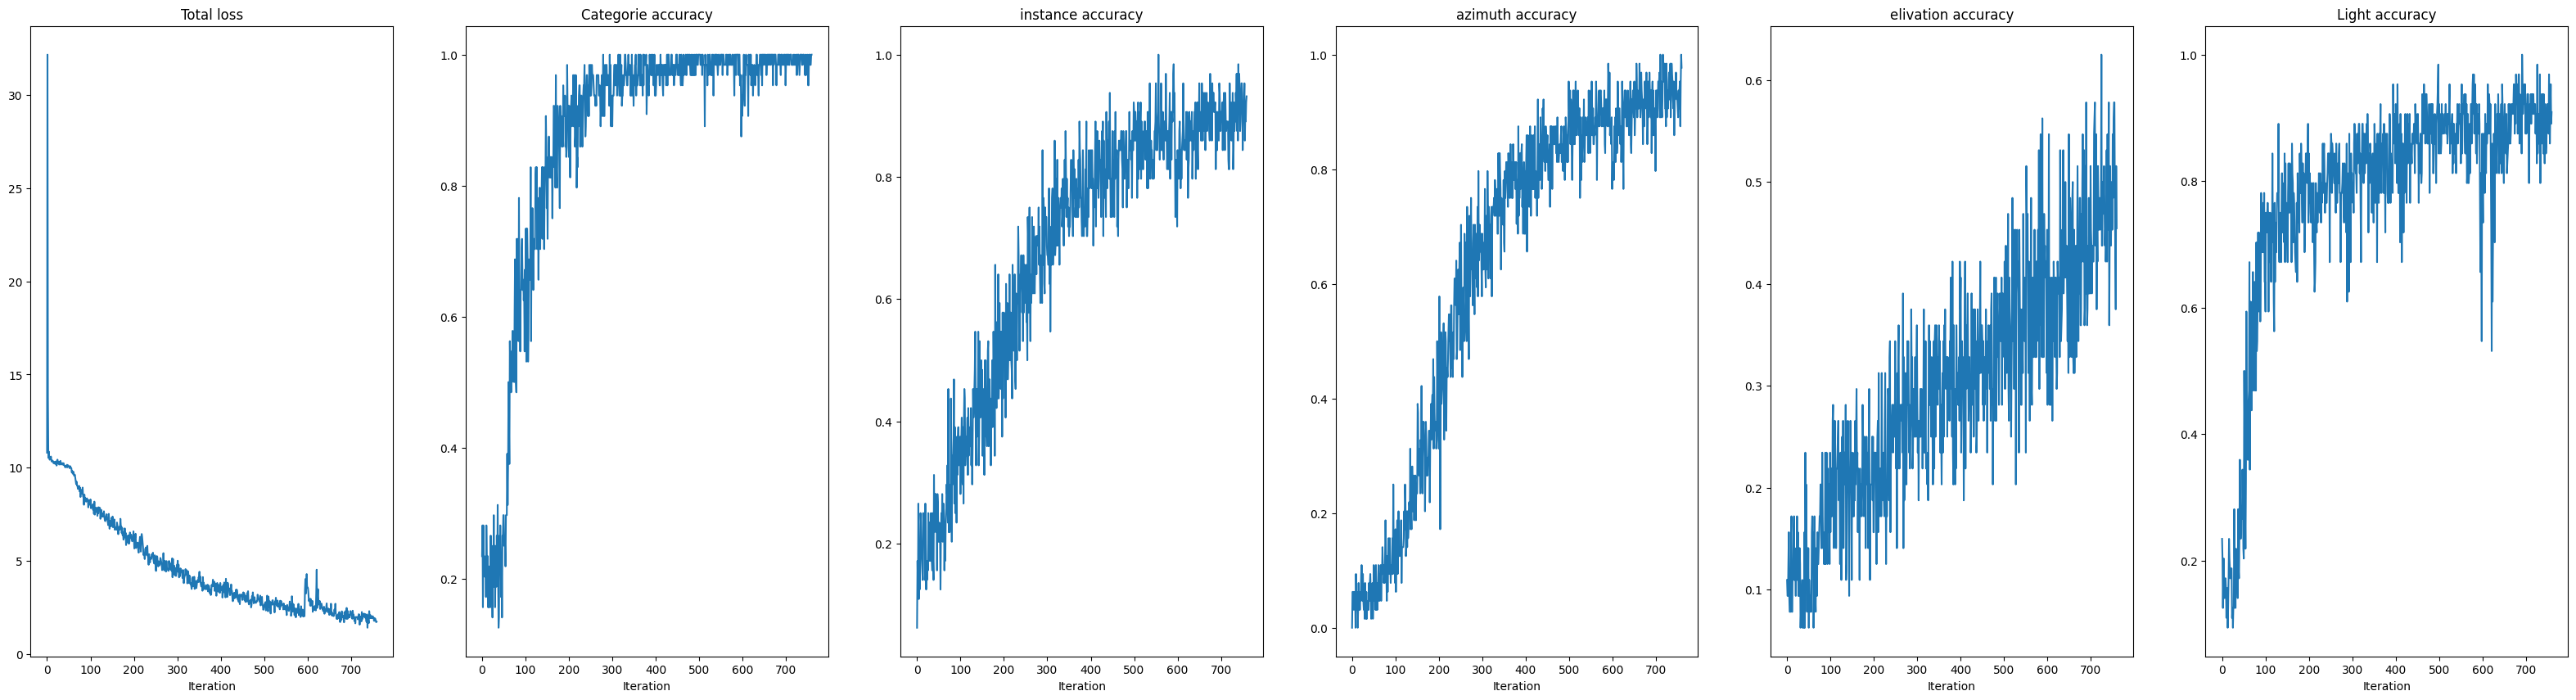

In [15]:
lists_loss_acc = [total_loss,lst_cat,lst_inst,lst_az,lst_ele,lst_light]
labels = ['Total loss', 'Categorie accuracy', 'instance accuracy','azimuth accuracy','elivation accuracy','Light accuracy']
fig,axs = plt.subplots(1,6,figsize=(40,10))
for i in range(6):
  axs[i].plot(lists_loss_acc[i])
  axs[i].set_title(labels[i])
  axs[i].set_xlabel('Iteration')

In [140]:
test_iter = iter(test_dataset)
id_to_cat = ['animal', 'human fig', 'airplane', 'truck', 'car']
elevations = [30,35,40,45,50,55,60,65,70]
azimuth = [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340]

In [141]:
timg,tlabs = create_batch(test_iter)
plabs = model.predict(timg)
pred_cat = np.argmax(plabs[0],axis=1)
pred_inst = np.argmax(plabs[1],axis=1)
pred_az = np.argmax(plabs[2],axis=1)
pred_elev = np.argmax(plabs[3],axis=1)
pred_light = np.argmax(plabs[4],axis=1)


2/2 [==============================] - 1s 474ms/step


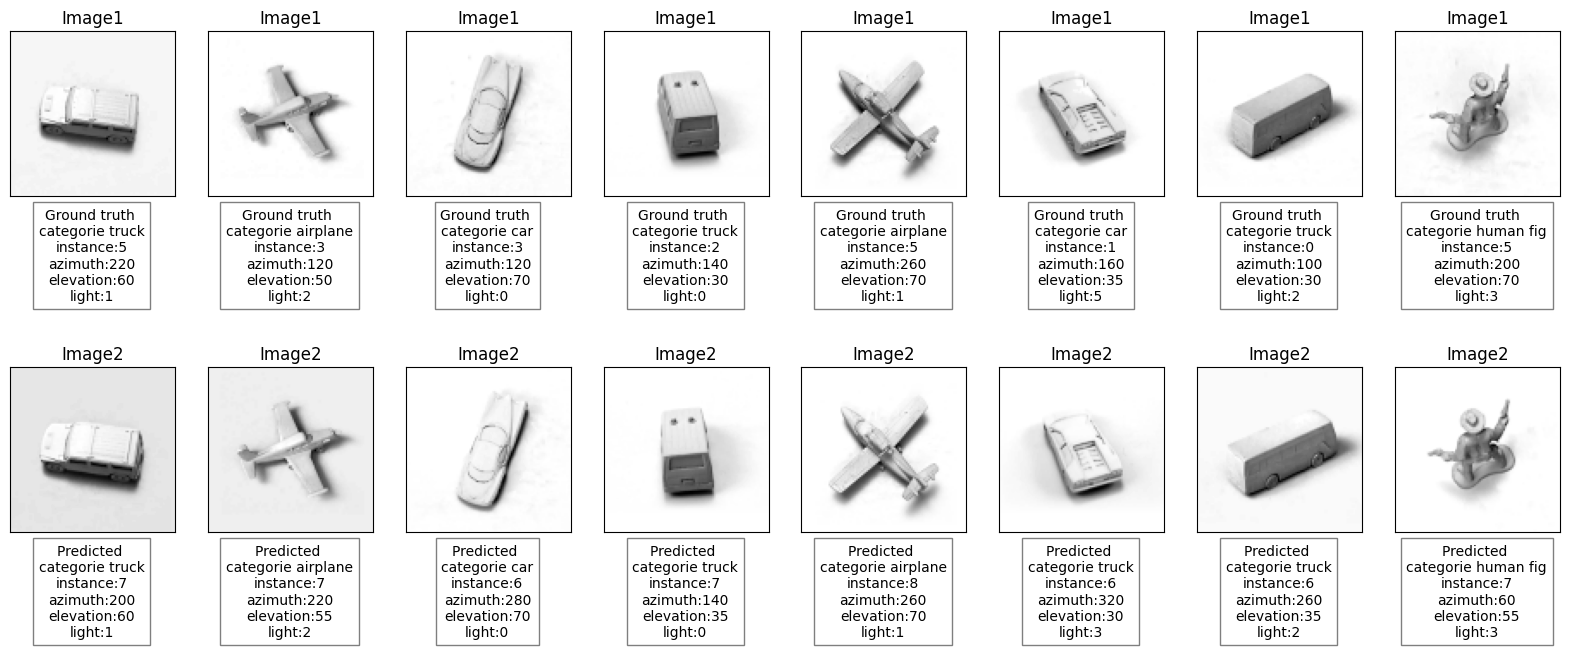

In [143]:
fig,axs = plt.subplots(2,8,figsize=(20,8))
for i in range(8):
  axs[0,i].imshow(timg[0][i],cmap='gray')
  axs[0,i].set_xticks([])
  axs[0,i].set_yticks([])
  discription = 'Ground truth \ncategorie ' + str(id_to_cat[int(tlabs[0][i])]) + '\ninstance:' + str(int(tlabs[1][i])) +'\n' +'azimuth:' + str(azimuth[tlabs[2][i]]) + '\n'
  discription = discription + 'elevation:' + str(elevations[int(tlabs[3][i])]) +  '\nlight:' + str(int(tlabs[4][i]))
  axs[0,i].text(47, 130, discription, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
  axs[0,i].set_title('Image1')
  axs[1,i].imshow(timg[1][i],cmap='gray')
  axs[1,i].set_xticks([])
  axs[1,i].set_yticks([])
  axs[1,i].set_title('Image2')
  discription = 'Predicted \ncategorie ' + str(id_to_cat[pred_cat[i]]) + '\ninstance:' + str(pred_inst[i]) +'\n' + 'azimuth:' + str(azimuth[pred_az[i]]) + '\n'
  discription = discription + 'elevation:' + str(elevations[pred_elev[i]]) +  '\nlight:' + str(pred_light[i])
  axs[1,i].text(47, 130, discription, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
